In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
twitter_data = pd.read_json('tweets_amd_mod.json', orient='split')
stock_data = pd.read_json('AMD-18-19.json')

In [3]:
import datetime
print(twitter_data.columns)
print(len(twitter_data))
print(stock_data.columns)
print(len(stock_data))
twitter_dataMod = twitter_data
print(len(twitter_dataMod))

twitter_dates = list(twitter_data.get('dates'))
stock_dates = list(stock_data.index)

stock_date = [k.ctime() for k in stock_dates]
stock_nptime = np.array([np.datetime64(k, 'D') for k in stock_dates])
print(stock_nptime)

minTime = '2018-01-01'
maxTime = '2019-07-08'

dates = np.arange(np.datetime64(minTime), np.datetime64(maxTime))
dates = dates[np.is_busday(dates)]
datesIncluded = len(dates)

print([k for k in dates if k not in stock_nptime])


Index(['dates', 'vader_mean', 'vader_std', 'volume', 'mean_exist',
       'std_exist'],
      dtype='object')
380
Index(['APO', 'Aroon Down', 'Real Middle Band', 'MIDPOINT', 'OBV', 'SINE',
       'QUADRATURE', 'open', 'close'],
      dtype='object')
380
380
['2018-01-02' '2018-01-03' '2018-01-04' '2018-01-05' '2018-01-08'
 '2018-01-09' '2018-01-10' '2018-01-11' '2018-01-12' '2018-01-16'
 '2018-01-17' '2018-01-18' '2018-01-19' '2018-01-22' '2018-01-23'
 '2018-01-24' '2018-01-25' '2018-01-26' '2018-01-29' '2018-01-30'
 '2018-01-31' '2018-02-01' '2018-02-02' '2018-02-05' '2018-02-06'
 '2018-02-07' '2018-02-08' '2018-02-09' '2018-02-12' '2018-02-13'
 '2018-02-14' '2018-02-15' '2018-02-16' '2018-02-20' '2018-02-21'
 '2018-02-22' '2018-02-23' '2018-02-26' '2018-02-27' '2018-02-28'
 '2018-03-01' '2018-03-02' '2018-03-05' '2018-03-06' '2018-03-07'
 '2018-03-08' '2018-03-09' '2018-03-12' '2018-03-13' '2018-03-14'
 '2018-03-15' '2018-03-16' '2018-03-19' '2018-03-20' '2018-03-21'
 '2018-03-22' '2

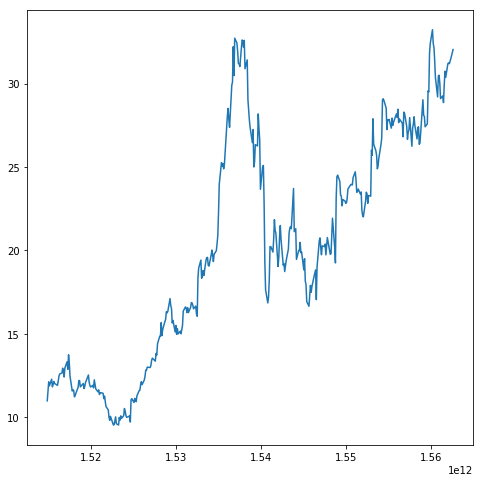

In [4]:
plt.figure(figsize=(8, 8))
plt.plot(twitter_dataMod.get('dates'), stock_data.get('close'))

In [5]:
# Shift the data to enable one-step t + 1 prediction

# Build the x and y values, note: x includes the previous opening price and closing prices

LAG_STEPS = 3 # Counted not including implied lag step of 1

dataLength = len(twitter_dataMod)-1

#twitter_dataMod2 = twitter_dataMod.drop(twitter_dataMod.index[[np.array(range(LAG_STEPS)), 
#                                                               dataLength-np.array(range(LAG_STEPS))]])
#stock_dataMod = stock_data.drop(stock_data.index[[np.array(range(LAG_STEPS)), 
#                                                               dataLength-np.array(range(LAG_STEPS))]])
#stock_dataMod2 = stock_data.drop(stock_data.index[np.array(range(LAG_STEPS*2))])
twitter_dataMod2 = twitter_dataMod.to_numpy()
twitter_dataMod2 = np.delete(twitter_dataMod2, 0, axis = 1)

stock_dataMod = stock_data.to_numpy()
stock_dataMod = np.delete(stock_dataMod, [7,8], axis = 1)

stock_dataMod2 = stock_data.to_numpy()
stock_dataMod2 = np.delete(stock_dataMod2, range(7), axis = 1)


for i in range(LAG_STEPS, dataLength):
    temp_twitter = (twitter_dataMod2[i - np.array(range(LAG_STEPS))]).reshape(1,-1)
    temp_stock = (stock_dataMod[i - np.array(range(LAG_STEPS))]).reshape(1,-1)
    temp_stock2 = (stock_dataMod[i - np.array(range(1, 1+LAG_STEPS))]).reshape(1,-1)
    if i == LAG_STEPS:
        x_unscaled = np.concatenate((temp_twitter, temp_stock, temp_stock2), axis = 1)
    else:
        temp_arr = np.concatenate((temp_twitter, temp_stock, temp_stock2), axis = 1)
        x_unscaled = np.concatenate((x_unscaled, temp_arr), axis = 0)

#twitter_dataMod2 = twitter_dataMod.to_numpy()
#twitter_dataMod2 = np.delete(twitter_dataMod2, 0, axis = 1)
#twitter_dataMod2 = np.delete(twitter_dataMod2, [np.array(range(LAG_STEPS)), dataLength-np.array(range(LAG_STEPS))], axis = 0)

#twitter_dataMod2 = twitter_dataMod.to_numpy()
#stock_dataMod = np.delete(stock_dataMod, [7,8], axis = 1)
#stock_dataMod = np.delete(stock_dataMod, [np.array(range(LAG_STEPS)), dataLength-np.array(range(LAG_STEPS))], axis = 0)

#stock_dataMod2 = stock_data.to_numpy()
#stock_dataMod2 = np.delete(stock_dataMod2, range(7), axis = 1)
#stock_dataMod2 = np.delete(stock_dataMod2, range(LAG_STEPS*2), axis = 0)

#x = np.vstack((twitter_dataMod2.get('vader_mean'), twitter_dataMod2.get('vader_std'), 
#          twitter_dataMod2.get('volume'), twitter_dataMod2.get('mean_exist'),
#          twitter_dataMod2.get('std_exist'))).T

#x2 = np.vstack((temp_stockMod[:, 0], temp_stockMod[:, 1], temp_stockMod[:, 2], 
#          temp_stockMod[:, 3], temp_stockMod[:, 4], temp_stockMod[:, 5],
#          temp_stockMod[:, 6], temp_stockMod2[:, 7], temp_stockMod2[:, 8])).T

#x_unscaled = np.concatenate((x, x2), axis=1)


#twitter_dataMod2 = twitter_dataMod.drop(twitter_dataMod.index[[0, 119]])
#stock_dataMod = stock_data.drop(stock_data.index[[0, 119]]).to_numpy()
#stock_dataMod2 = stock_data.drop(stock_data.index[[118, 119]]).to_numpy()

print(len(x_unscaled))
print(x_unscaled[0])

stock_dataMod3 = stock_data.drop(stock_data.index[range(LAG_STEPS+1)]).to_numpy()

y_open = stock_dataMod3[:, 7].reshape(-1,1)
y_close = stock_dataMod3[:, 8].reshape(-1,1)
print(y_open.size)

376
[ 1.62500000e-01  2.33501363e-01  3.00000000e+00  1.00000000e+00
  1.00000000e+00 -6.45000000e-02  4.22856328e-01  7.00000000e+00
  1.00000000e+00  1.00000000e+00  3.58033333e-01  2.85042281e-01
  3.00000000e+00  1.00000000e+00  1.00000000e+00  3.91800000e-01
  6.50000000e+01  1.17106000e+01  1.22300000e+01  1.37434323e+09
  5.37000000e-02  6.97200000e-01  3.16300000e-01  6.66667000e+01
  1.17368000e+01  1.22300000e+01  1.43753122e+09  3.44000000e-02
  2.40200000e-01  1.67000000e-01  6.83333000e+01  1.17601000e+01
  1.22300000e+01  1.32901881e+09  1.24400000e-01 -6.37000000e-01
  3.16300000e-01  6.66667000e+01  1.17368000e+01  1.22300000e+01
  1.43753122e+09  3.44000000e-02  2.40200000e-01  1.67000000e-01
  6.83333000e+01  1.17601000e+01  1.22300000e+01  1.32901881e+09
  1.24400000e-01 -6.37000000e-01  3.05000000e-02  7.00000000e+01
  1.17810000e+01  1.22300000e+01  1.17892125e+09  6.01800000e-01
 -1.39470000e+00]
376


In [6]:
# standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy = True, with_mean = True, with_std = True)
scaler.fit(x_unscaled)
x = (scaler.transform(x_unscaled))
# import the splitting library
from sklearn.model_selection import train_test_split

0.9811527007840175
0.9627125111965288


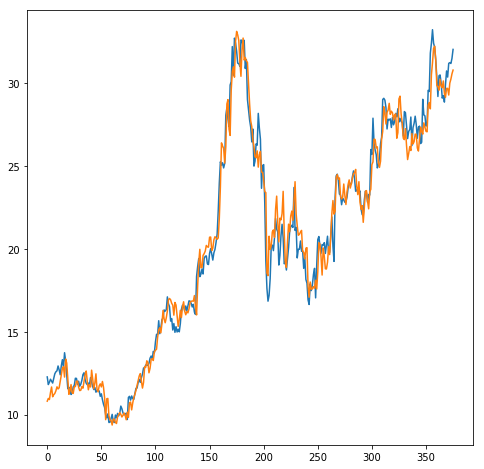

In [7]:
# basic linear regression
from sklearn import linear_model
x_train, x_test, y_train, y_test = train_test_split(x, y_close, test_size = 0.20)
reg = linear_model.LinearRegression().fit(x_train, y_train)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(range(len(x_unscaled)), y_close)
plt.plot(range(len(x_unscaled)), reg.predict(x))

0.0001
0.9823524859501763
0.9517482850385444


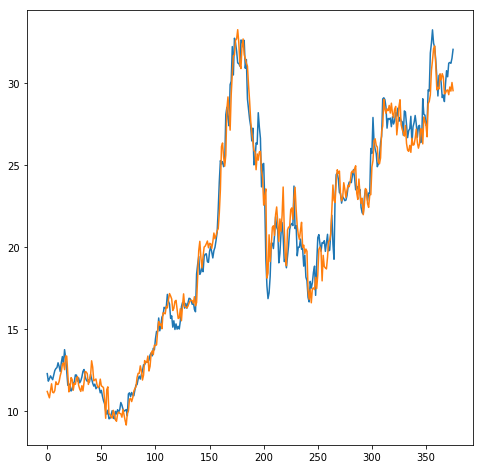

In [8]:
# ridge regression
x_train, x_test, y_train, y_test = train_test_split(x, y_close, test_size = 0.20)
reg = linear_model.RidgeCV(alphas = np.logspace(-4, 4, 9), fit_intercept = True)
reg.fit(x_train, y_train)
print(reg.alpha_)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(range(len(x_unscaled)), y_close)
plt.plot(range(len(x_unscaled)), reg.predict(x))

0.8470520516317604
0.8340293621881889


C:\Users\patel\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.893e-01, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\patel\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.463e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\patel\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=7.660e-02, with an active set of 6 regressors, and the smallest cholesky pivot

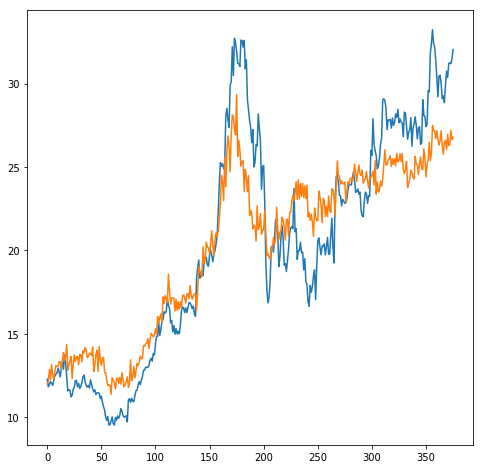

In [9]:
# lasso regression (LARS)
x_train, x_test, y_train, y_test = train_test_split(x, y_close, test_size = 0.20)
reg = linear_model.LassoLars(alpha = 0.01, fit_path = True, fit_intercept = True, precompute = 'auto', max_iter = 10)

reg.fit(x_train, y_train)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(range(len(x_unscaled)), y_close)
plt.plot(range(len(x_unscaled)), reg.predict(x))

C:\Users\patel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\patel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.9866666666666667
0.0


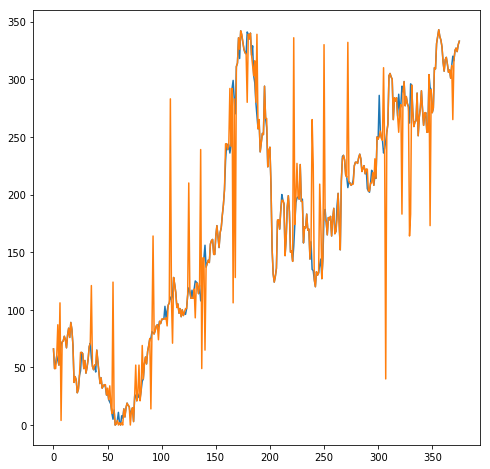

In [10]:
# Logistic regression
from sklearn import preprocessing

lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(np.ravel(y_close))

x_train, x_test, y_train, y_test = train_test_split(x, encoded, test_size = 0.20)
reg = linear_model.LogisticRegression().fit(x_train, np.ravel(y_train))
print(reg.score(x_train, np.ravel(y_train)))
print(reg.score(x_test, np.ravel(y_test)))
plt.figure(figsize=(8, 8))
plt.plot(range(len(x_unscaled)), encoded)
plt.plot(range(len(x_unscaled)), reg.predict(x))

0.9359414981210323
0.9458229686796461


C:\Users\patel\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


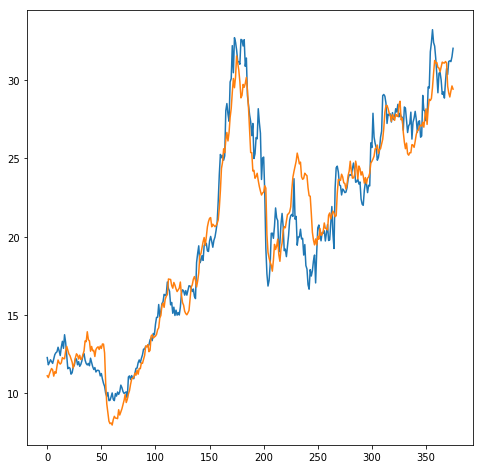

In [11]:
# Bayesian Ridge Regression
x_train, x_test, y_train, y_test = train_test_split(x, y_close, test_size = 0.20)
reg = linear_model.BayesianRidge(compute_score = True)
reg.fit(x_train, y_train)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(range(len(x_unscaled)), y_close)
plt.plot(range(len(x_unscaled)), reg.predict(x))

1.0
0.6527734575894897


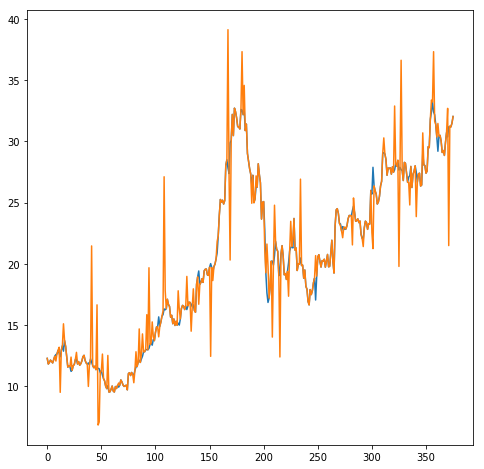

In [12]:
# Extend linear regression to polynomial 
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
z = poly.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(z, y_close, test_size = 0.20)
reg = linear_model.LinearRegression().fit(x_train, y_train)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(range(len(x_unscaled)), y_close)
plt.plot(range(len(x_unscaled)), reg.predict(z))

100.0
0.9857762479519695
0.9189834415198501


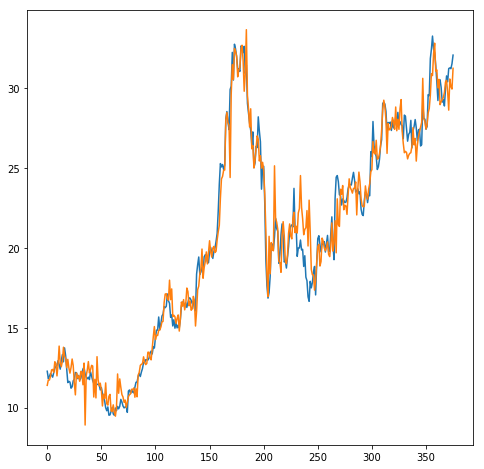

In [13]:
# Extend ridge regression to polynomial 

poly = PolynomialFeatures(degree=2)
z = poly.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(z, y_close, test_size = 0.20)
reg = linear_model.RidgeCV(alphas = np.logspace(-5, 5, 11), fit_intercept = True)
reg.fit(x_train, y_train)
print(reg.alpha_)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(range(len(x_unscaled)), y_close)
plt.plot(range(len(x_unscaled)), reg.predict(z))

0.810302043938242
0.8060678543865207


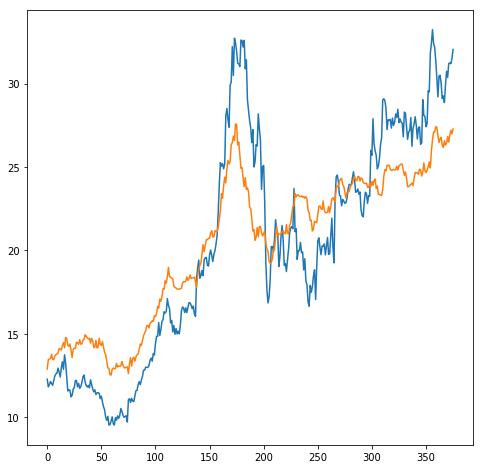

In [14]:
# Extend lasso regression to polynomial
poly = PolynomialFeatures(degree=4)
z = poly.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(z, y_close, test_size = 0.20)
reg = linear_model.LassoLars(alpha = 0.1, fit_intercept = True, precompute = 'auto',
                            fit_path = True, max_iter = 6)
reg.fit(x_train, y_train)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(range(len(x_unscaled)), y_close)
plt.plot(range(len(x_unscaled)), reg.predict(z))

C:\Users\patel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\patel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


1.0
0.0


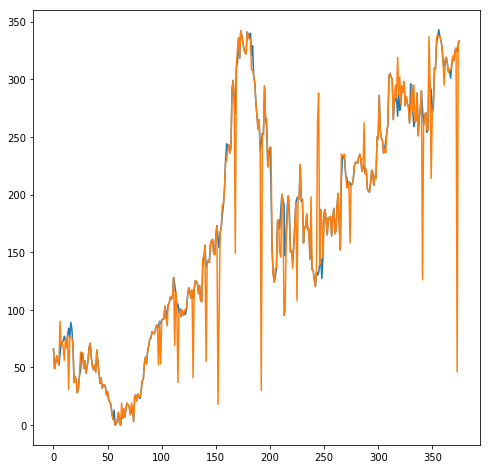

In [15]:
# extend logistic regression to polynomial
poly = PolynomialFeatures(degree=2)
z = poly.fit_transform(x)

from sklearn import preprocessing

lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(np.ravel(y_close))

x_train, x_test, y_train, y_test = train_test_split(z, encoded, test_size = 0.20)
reg = linear_model.LogisticRegression().fit(x_train, np.ravel(y_train))
print(reg.score(x_train, np.ravel(y_train)))
print(reg.score(x_test, np.ravel(y_test)))
plt.figure(figsize=(8, 8))
plt.plot(range(len(x_unscaled)), encoded)
plt.plot(range(len(x_unscaled)), reg.predict(z))

0.9874237526297769
0.9366783794421467


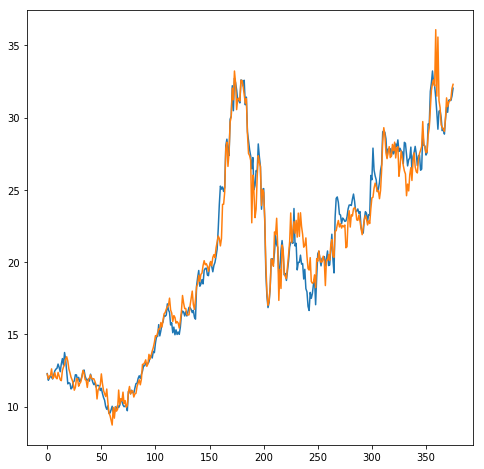

In [16]:
# extend bayesian regression to polynomial
poly = PolynomialFeatures(degree=3)
z = poly.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(z, y_close, test_size = 0.20)
reg = linear_model.BayesianRidge(compute_score = True)
reg.fit(x_train, np.ravel(y_train))
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(range(len(x_unscaled)), y_close)
plt.plot(range(len(x_unscaled)), reg.predict(z))

0.9999407236025158
0.8992927269764929


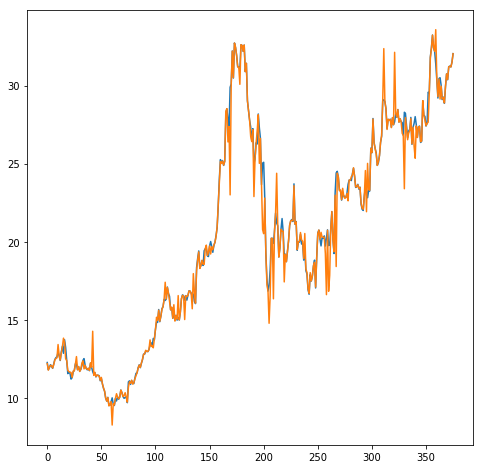

In [17]:
# Kernel ridge regression

from sklearn.kernel_ridge import KernelRidge

x_train, x_test, y_train, y_test = train_test_split(x, y_close, test_size = 0.20)
reg = KernelRidge(alpha=0.01, coef0=1, degree=3, kernel='poly')
reg.fit(x_train, y_train)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(range(len(x_unscaled)), y_close)
plt.plot(range(len(x_unscaled)), reg.predict(x))

0.9980193930764613
0.915094870329873


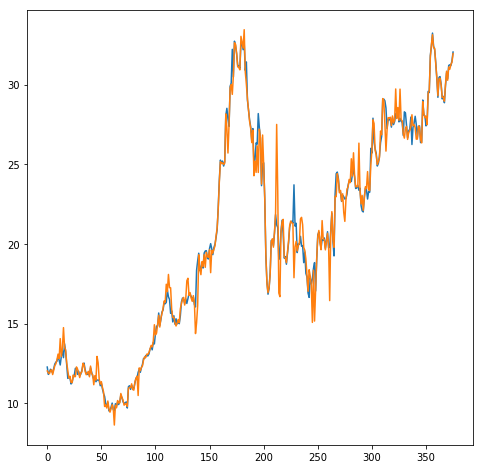

In [18]:
# Support Vector Regression
from sklearn.svm import SVR

x_train, x_test, y_train, y_test = train_test_split(x, y_close, test_size = 0.20)

reg = SVR(kernel='rbf', max_iter=-1, gamma= 0.001, C = 10000)
reg.fit(x_train, np.ravel(y_train))
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(range(len(x_unscaled)), y_close)
plt.plot(range(len(x_unscaled)), reg.predict(x))

0.9976356953217674
0.959113363668286


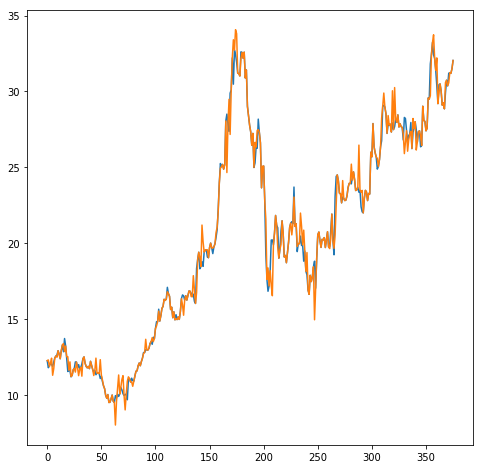

In [19]:
# Support Vector Regression
from sklearn.svm import NuSVR

x_train, x_test, y_train, y_test = train_test_split(x, y_close, test_size = 0.20)

reg = NuSVR(nu = 0.5, kernel='rbf', max_iter=-1, gamma= 0.001, C = 10000)
reg.fit(x_train, np.ravel(y_train))
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(range(len(x_unscaled)), y_close)
plt.plot(range(len(x_unscaled)), reg.predict(x))

1.0
0.9265506272958015


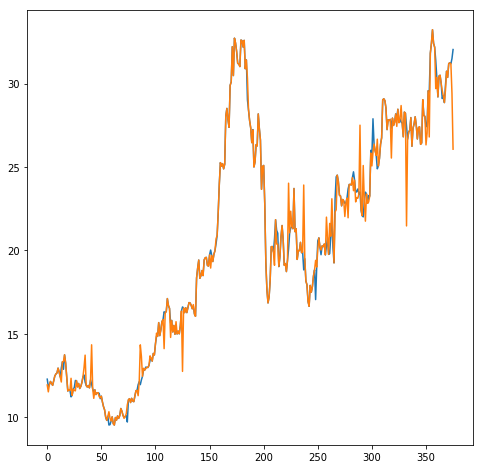

In [20]:
# Nearest Neighbors Regression
from sklearn.neighbors import KNeighborsRegressor

x_train, x_test, y_train, y_test = train_test_split(x, y_close, test_size = 0.20)

reg = KNeighborsRegressor(n_neighbors=4, weights = 'distance')
reg.fit(x_train, y_train)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(range(len(x_unscaled)), y_close)
plt.plot(range(len(x_unscaled)), reg.predict(x))

1.0
0.04351484275648487


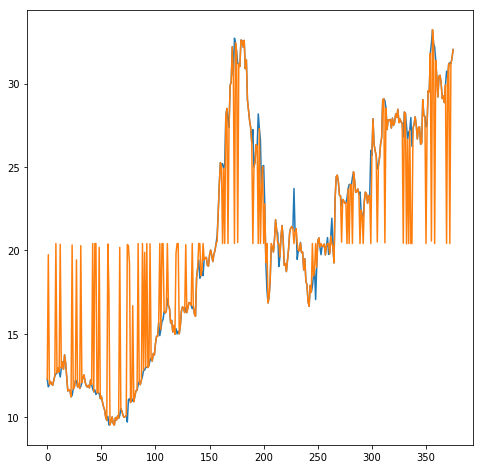

In [21]:
# Gaussian Process Regressor
from sklearn.gaussian_process import GaussianProcessRegressor

x_train, x_test, y_train, y_test = train_test_split(x, y_close, test_size = 0.20)

reg = GaussianProcessRegressor(normalize_y = True, alpha = 1e-10)
reg.fit(x_train, y_train)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(range(len(x_unscaled)), y_close)
plt.plot(range(len(x_unscaled)), reg.predict(x))

1.0
0.9544832771589249


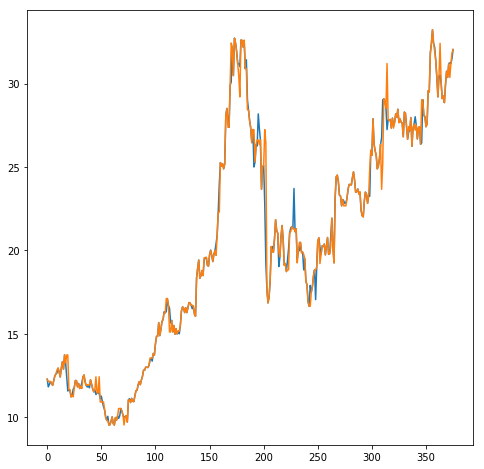

In [36]:
# Random Decision Tree
from sklearn import tree

x_train, x_test, y_train, y_test = train_test_split(x, y_close, test_size = 0.20)

reg = tree.DecisionTreeRegressor()
reg.fit(x_train, y_train)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(range(len(x_unscaled)), y_close)
plt.plot(range(len(x_unscaled)), reg.predict(x))

0.9904846736073091
0.9400848706350653


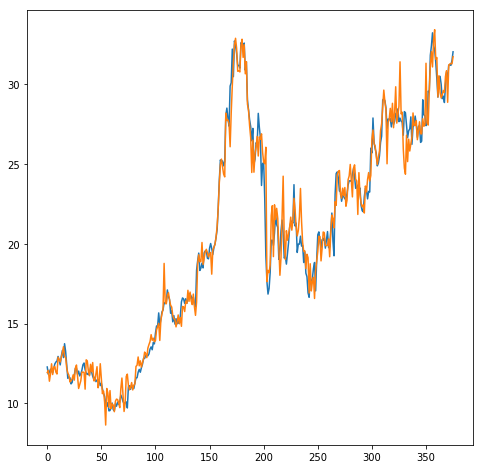

In [52]:
# Bagging NuSVR
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import NuSVR
 
x_train, x_test, y_train, y_test = train_test_split(x, y_close, test_size = 0.20)

reg = BaggingRegressor(NuSVR(nu = 0.5, kernel='rbf', max_iter=-1, gamma= 0.001, C = 10000))
reg.fit(x_train, np.ravel(y_train))
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(range(len(x_unscaled)), y_close)
plt.plot(range(len(x_unscaled)), reg.predict(x))

0.9953491773511338
0.971499449796898


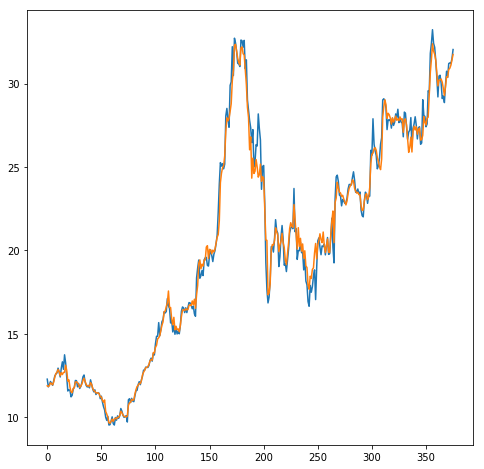

In [56]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

x_train, x_test, y_train, y_test = train_test_split(x, y_close, test_size = 0.20)

reg = RandomForestRegressor(n_estimators = 250)
reg.fit(x_train, np.ravel(y_train))
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(range(len(x_unscaled)), y_close)
plt.plot(range(len(x_unscaled)), reg.predict(x))

1.0
0.9863627091916629


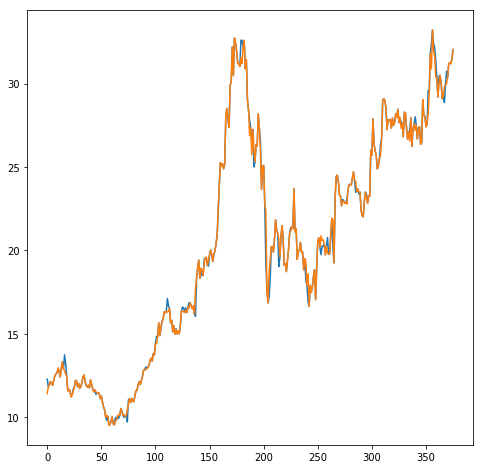

In [61]:
# Extra Trees Regressor
from sklearn.ensemble import ExtraTreesRegressor

x_train, x_test, y_train, y_test = train_test_split(x, y_close, test_size = 0.20)

reg = ExtraTreesRegressor(n_estimators = 100)
reg.fit(x_train, np.ravel(y_train))
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(range(len(x_unscaled)), y_close)
plt.plot(range(len(x_unscaled)), reg.predict(x))

0.9972738376264352
0.9828908155116923


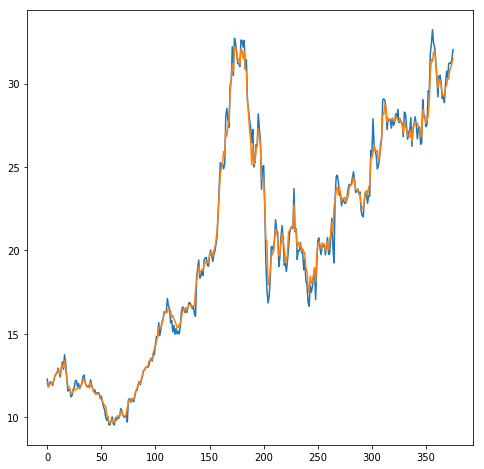

In [63]:
# Bagging Extreme Random Trees
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor

x_train, x_test, y_train, y_test = train_test_split(x, y_close, test_size = 0.20)

reg = BaggingRegressor(ExtraTreesRegressor(n_estimators = 100), n_estimators = 100)
reg.fit(x_train, np.ravel(y_train))
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(range(len(x_unscaled)), y_close)
plt.plot(range(len(x_unscaled)), reg.predict(x))

0.9996951145331942
0.9759229430529808


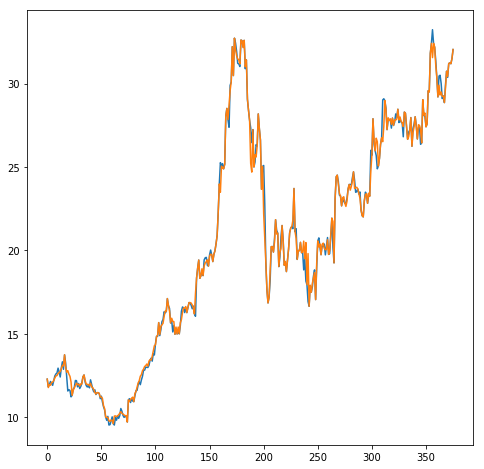

In [71]:
# AdaBoost regressor Extreme Random Trees
from sklearn.ensemble import AdaBoostRegressor

from sklearn.ensemble import ExtraTreesRegressor

x_train, x_test, y_train, y_test = train_test_split(x, y_close, test_size = 0.20)

reg = AdaBoostRegressor(ExtraTreesRegressor(n_estimators = 100),
    n_estimators = 100)
reg.fit(x_train, np.ravel(y_train))
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(range(len(x_unscaled)), y_close)
plt.plot(range(len(x_unscaled)), reg.predict(x))

0.9999999978493378
0.9751758163696104


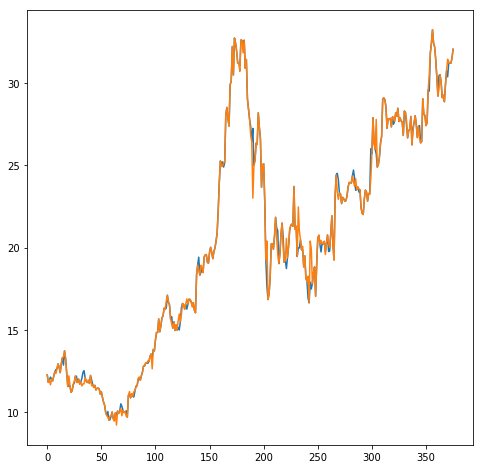

In [75]:
# Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

x_train, x_test, y_train, y_test = train_test_split(x, y_close, test_size = 0.20)

reg = GradientBoostingRegressor(n_estimators = 100000)
reg.fit(x_train, np.ravel(y_train))
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(range(len(x_unscaled)), y_close)
plt.plot(range(len(x_unscaled)), reg.predict(x))

0.9993229606778986
0.8764957582170184


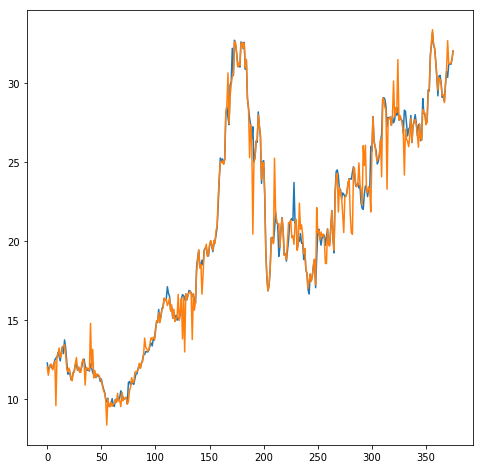

In [82]:
# Neural Network Multi-layer Perceptron
from sklearn.neural_network import MLPRegressor

x_train, x_test, y_train, y_test = train_test_split(x, y_close, test_size = 0.20)

reg = MLPRegressor(hidden_layer_sizes = (100,), activation = 'relu', 
                  solver = 'adam', alpha = 0.0001, batch_size = 'auto',
                  learning_rate = 'constant', max_iter = 5000)
reg.fit(x_train, np.ravel(y_train))
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))
plt.figure(figsize=(8, 8))
plt.plot(range(len(x_unscaled)), y_close)
plt.plot(range(len(x_unscaled)), reg.predict(x))